<a href="https://colab.research.google.com/github/pachterlab/BMGP_2020/blob/main/analysis/notebooks/barcode_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --quiet https://github.com/sbooeshaghi/BMGP_2020

In [2]:
!pip install --upgrade --quiet setuptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [3]:
!pip install --quiet git+https://github.com/sbooeshaghi/qcbc.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from qcbc.qcbc_volume import qcbc_volume
from qcbc.qcbc_ambiguous import qcbc_ambiguous
from qcbc.qcbc_pdist import qcbc_pdist
from qcbc.qcbc_content import qcbc_content, qcbc_content_T
from qcbc.qcbc_homopolymer import qcbc_homopolymer
from qcbc.utils import make_ec, load_bcs, list_ambiguous

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
fb_fn = "BMGP_2020/references/10xFB/kite/feature_barcodes.txt"
bcs, bcs_names = load_bcs(fb_fn)

In [6]:
# volume
x  = np.arange(2,len(bcs[0]) + 1)
bc_len = min([len(i) for i in bcs])
print(f"{qcbc_volume(bc_len):,.0f}")

# ambiguity
ambig_bcs = qcbc_ambiguous(*[make_ec(bcs, bcs_names, i) for i in x])
nbc = np.array([len(i) for i in list_ambiguous(ambig_bcs)])

# pdist
pdist = qcbc_pdist(bcs)
pdist_rc = qcbc_pdist(bcs, True)

# content
content = entropy(np.array([list(i["freq"].values()) for i in qcbc_content(bcs, bcs_names)]), axis=1) / np.log2(4)
content_T = np.array([list(i["freq"].values()) for i in qcbc_content_T(bcs, bcs_names)]).T
# homopolymer
hp = np.array([list(i["homopolymers"].values()) for i in qcbc_homopolymer(bcs, bcs_names)])

1,073,741,824


<ipython-input-7-25a951339421>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**{


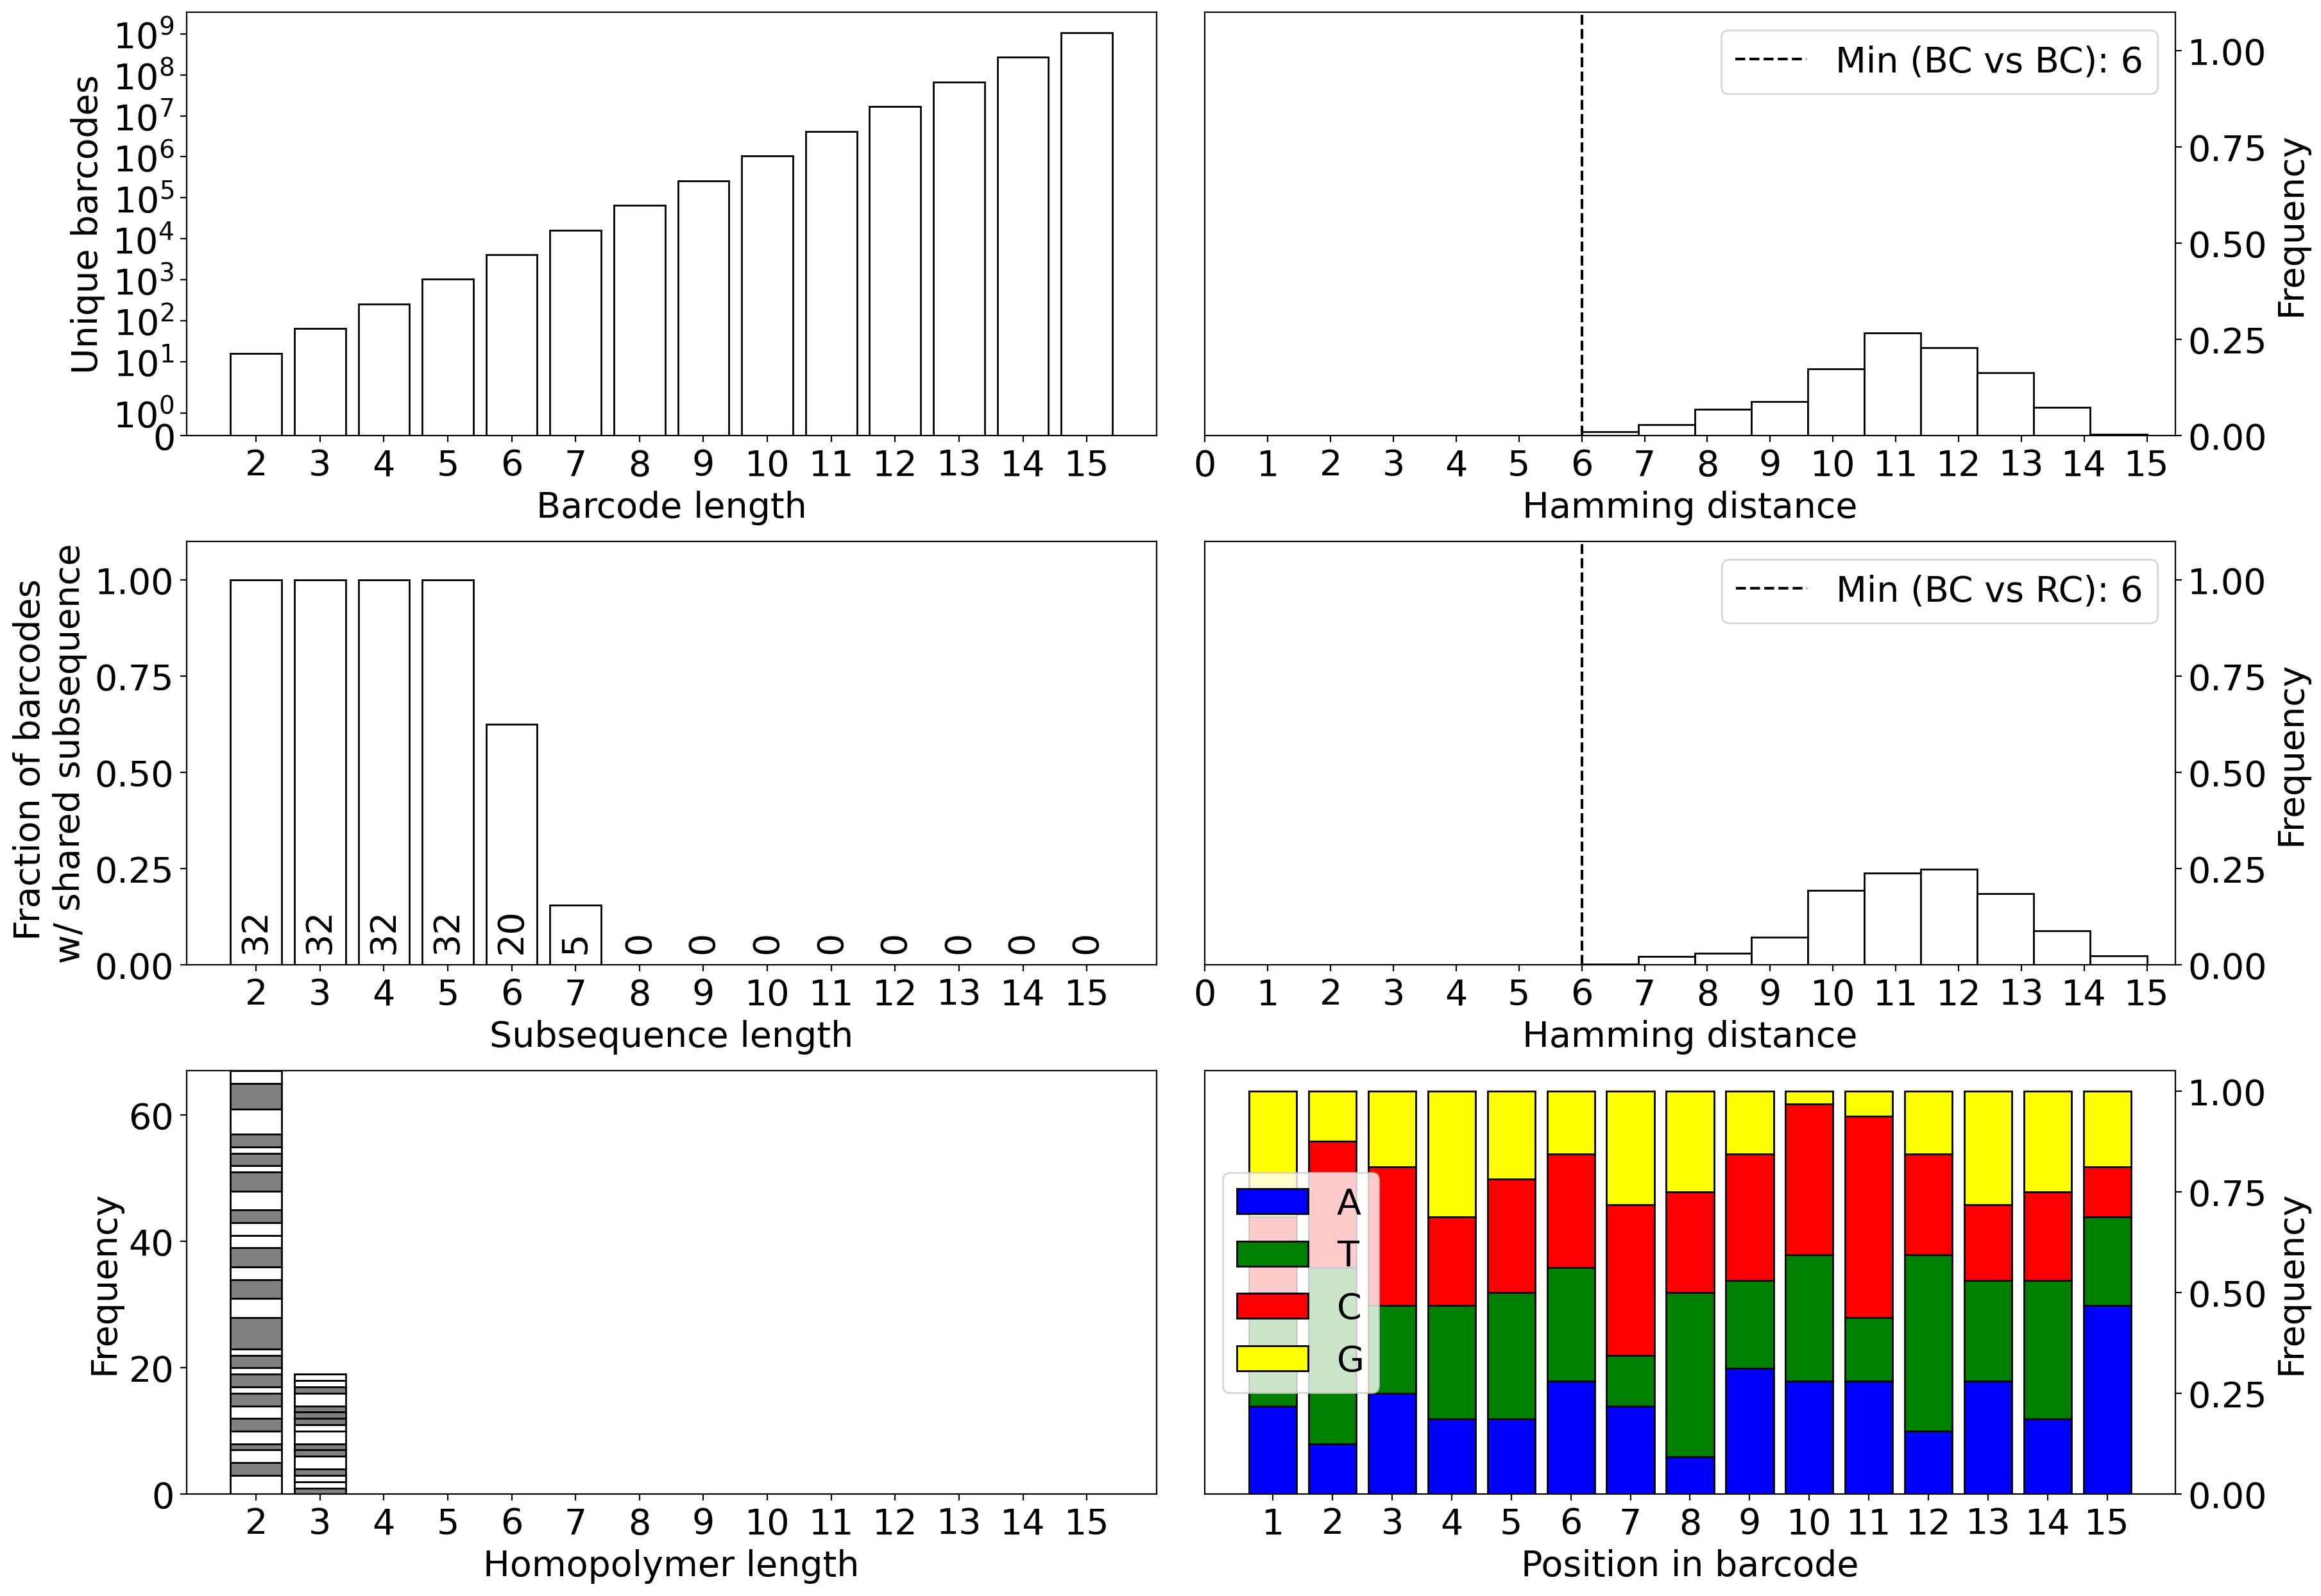

In [7]:
fig, axs = plt.subplots(figsize=(20,15), ncols=2, nrows=3)
fig.subplots_adjust(hspace=0.25, wspace=0.05)

## Barcode diversity
ax = axs[0,0]
x  = np.arange(2,len(bcs[0]) + 1)
y = 4**x

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "yscale": "symlog",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": "Unique barcodes"
})


#############################################
# Shared subseq
ax = axs[1, 0]
y = nbc / len(bcs)

for idx, (xx, yy) in enumerate(zip(x,y)):
  ax.text(xx, 0.05, f"{nbc[idx]:,.0f}", ha="center", rotation=90)

ax.bar(x, y, edgecolor="k", color="white")
ax.set(**{
    "ylim": (0, 1.1),
    "xticks": x,
    "xlabel": "Subsequence length",
    "ylabel": "Fraction of barcodes \nw/ shared subsequence",
})

#############################################
## Pairwise hamming
ax = axs[0,1]
x = pdist
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs BC): {mn:,.0f}", color="k", linestyle="--")
ax.set(**{
    "xlabel": "Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    # "xticklabels": []
})
ax.legend()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

########################################
ax = axs[1,1]
x = pdist_rc
ax.hist(x, density=True, edgecolor="k", color="white")
mn = min(x)
ax.axvline(mn, label=f"Min (BC vs RC): {mn:,.0f}", color="k", linestyle="--")

ax.set(**{
    "xlabel": "Hamming distance",
    "ylabel": "Frequency",
    "ylim": (0,1.1),
    "xticks": np.arange(0, int(max(x))+1),
    "xticklabels": np.arange(0, int(max(x))+1),
})
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.legend()

#######################################
# homopolymer
ax = axs[2,0]
toggle = itertools.cycle(["white", "grey"]).__next__

x = np.arange(hp.shape[1])+2
y = hp[0].copy()
ax.bar(x,y, edgecolor="k", facecolor=toggle())
for r in hp[1:]:
  ax.bar(x,r, bottom=y, edgecolor="k", facecolor=toggle())
  y+=r

ax.set(**{
    "xlabel": "Homopolymer length",
    "ylabel": "Frequency",
    "xticklabels": x,
    "xticks": x
})

# Content
ax = axs[2,1]
# x = content
# ax.hist(x, edgecolor="k", facecolor="white", bins=5)
# ax.set(**{
#     "xlim": (0, 1),
#     "xlabel": "Max-entropy fraction of nucleotide content",
#     "ylabel": "Frequency"
# })

x = np.arange(content_T.shape[1])+1
y = content_T[0].copy()
colors = ["blue", "green", "red", "yellow"]
bases = ["A", "T", "C", "G"]
ax.bar(x,y, edgecolor="k", facecolor="blue", label=bases[0])
for idx, d in enumerate(content_T[1:], 1):
  ax.bar(x,d, bottom=y, edgecolor="k", facecolor=colors[idx], label=bases[idx])
  y+=d

ax.set(**{
    "xlabel": "Position in barcode",
    "ylabel": "Frequency",
    "xticks": x
})
ax.legend()

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
fig.savefig("qcbc.png", dpi=300, bbox_inches="tight")
fig.show()

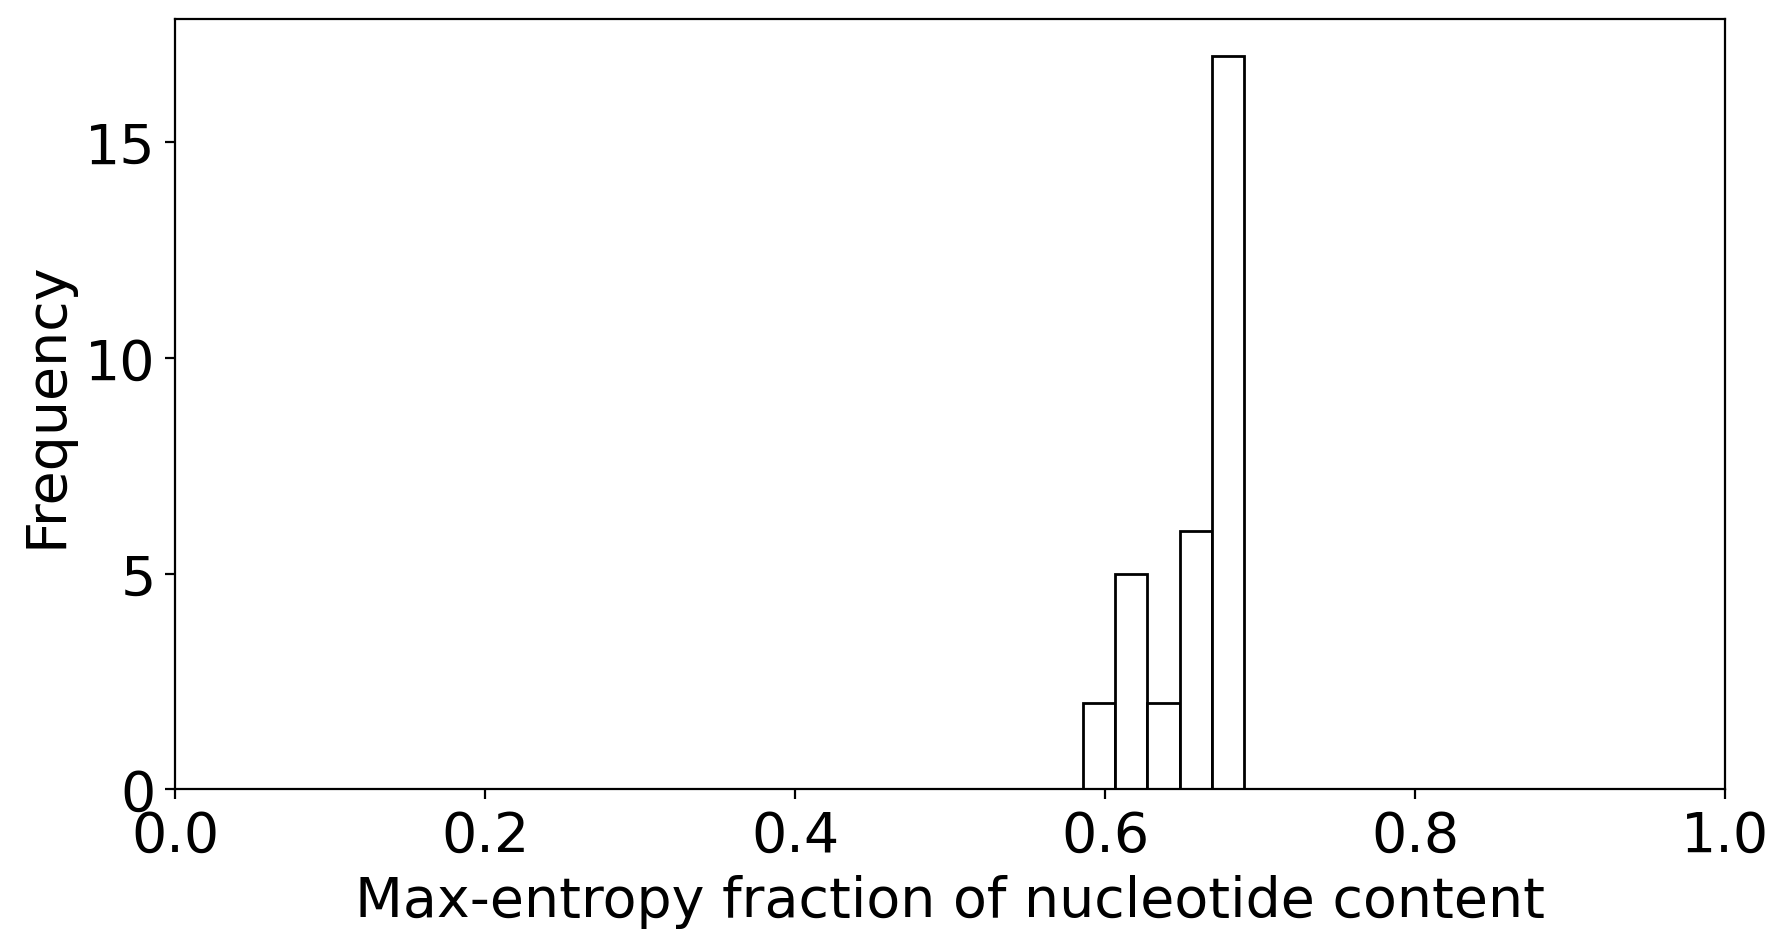

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

x = content
ax.hist(x, edgecolor="k", facecolor="white", bins=5)
ax.set(**{
    "xlim": (0, 1),
    "xlabel": "Max-entropy fraction of nucleotide content",
    "ylabel": "Frequency"
})
fig.savefig("nucleotide-content-per-bc-entropy.png", dpi=300, bbox_inches="tight")
fig.show()

In [8]:
# whta is the figure you want to make
# x axis is barcode length
# y axis is number of barcodes
# c is the fraction of barcodes that a hamming 1 distance correction rescures (relative to what can be resuced)
# or we fix the number of barcodes from the assay
# and we vary the size of the correction D

In [11]:
import scipy.special
# N = length of codeword
# D is min ham
# q is alphabet size
def hamming_bound(N, D, q=4):
    t = (D - 1) // 2
    denominator = sum(scipy.special.comb(N, i) * (q - 1)**i for i in range(t + 1))
    if denominator == 0:
        return 0  # Avoid division by zero
    return q**N / denominator

# Example usage:
# For a barcode of length N, minimum distance D, and alphabet size q:
N = 10
D = 3
q = 4
bound_value = hamming_bound(N, D, q)
print(f'Hamming Bound: {bound_value}')


Hamming Bound: 33825.032258064515


In [12]:
hb = [hamming_bound(i, 3) for i in range(2, 16)]

In [37]:
n1ham = []
for i in range(2, len(bcs) + 1):
  n1ham .append([(3*j + 1)*i for j in range(2, 16)])

n1ham = np.array(n1ham)

In [ ]:
nNham = []
for i in range(1, 4):


In [42]:
frac = n1ham / np.repeat([hb], n1ham.shape[0], axis=0)

<ipython-input-61-f6b4bb45a98b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**{


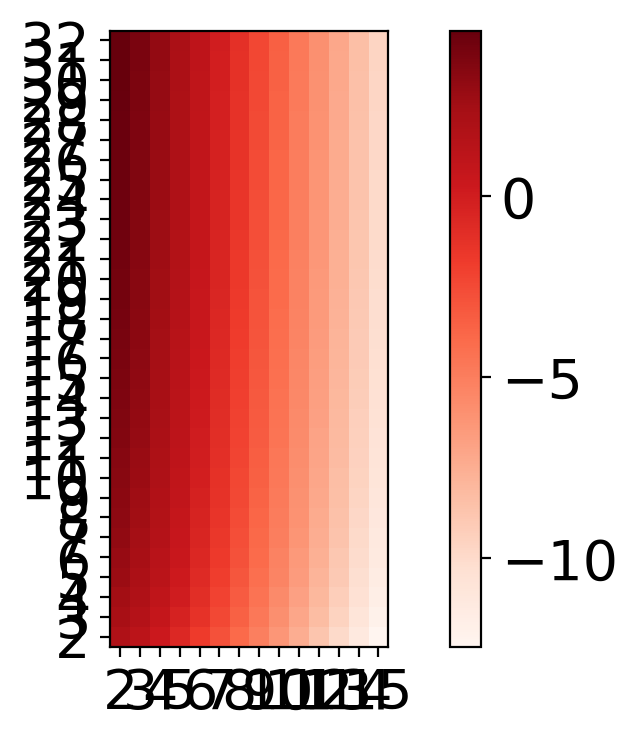

In [61]:
fig, ax = plt.subplots(figsize=(8,4))

x = np.arange(2, 16)
y = np.arange(2, len(bcs) + 1)
cmat = ax.imshow(np.log(frac), aspect="auto", origin="lower", cmap="Reds", interpolation="none")

fig.colorbar(cmat)
ax.set(**{
    "xticks": x - 2,
    "xticklabels": x,
    "yticklabels": y,
    "yticks": y - 2
})
fig.show()

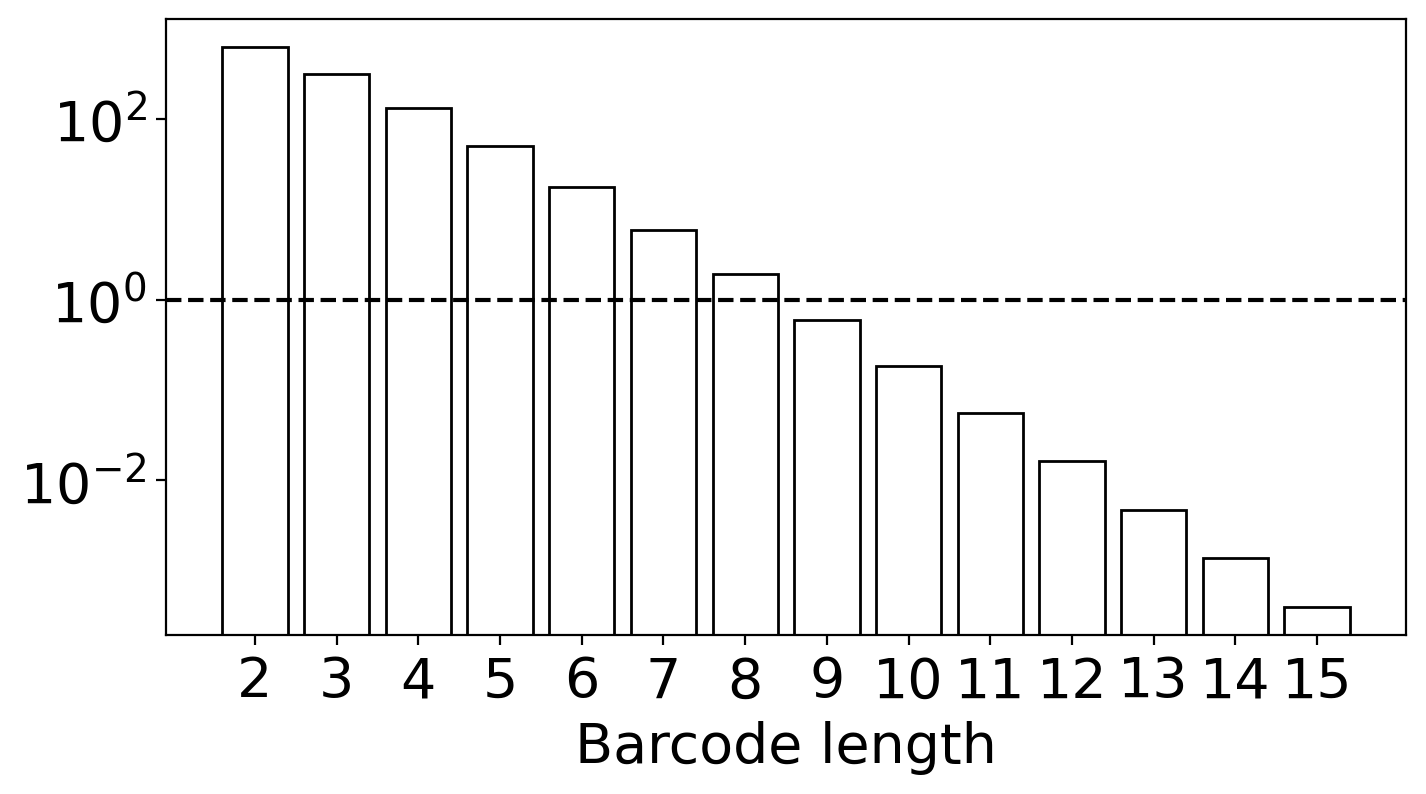

In [62]:
fig, ax = plt.subplots(figsize=(8,4))

## Barcode diversity
x  = np.arange(2,len(bcs[0]) + 1)
y = np.array(nb) / np.array(hb)

ax.bar(x, y, edgecolor="k", color="white",)
ax.axhline(y=1, linestyle="--", color="k")
ax.set(**{
    "yscale": "log",
    "xticks": x,
    "xlabel": "Barcode length",
    "ylabel": ""
})
fig.show()